# Image Classification
In this project, we'll classify images from the classic [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  We'll build a convolutional, max pooling, dropout, and fully connected layers.  At the end, we'll see your neural network's predictions on the sample images.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'
cifar10_dataset_compressed_file = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


if not isfile(cifar10_dataset_compressed_file):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            cifar10_dataset_compressed_file,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(cifar10_dataset_compressed_file) as tar:
        tar.extractall()
        tar.close()

tests.test_folder_path(cifar10_dataset_folder_path)


c:\users\jesús\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


All files found!


## Explore the Data
The dataset is broken into batches to prevent our machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Feel free to play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


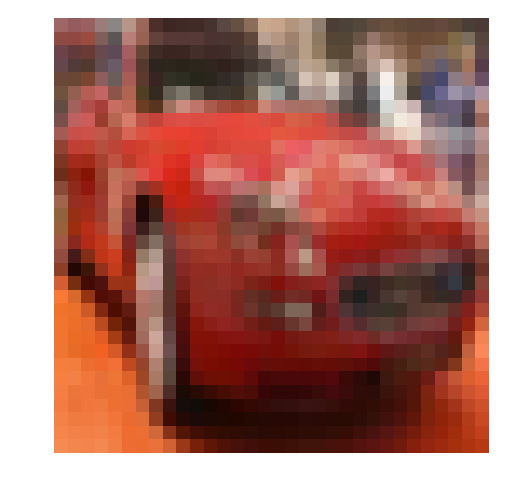

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

NUM_LABELS = 10
# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implementation of Preprocessing Functions

### Normalize

In [3]:
def normalize(x):
    """
    Normalizes a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return (255.0 - x.astype(float)) / 255.0


tests.test_normalize(normalize)

Tests Passed


### One-hot encode
The input, `x`, is a list of labels.  The function will return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function will return the same encoding for each value between each call to `one_hot_encode`.

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return ((np.arange(NUM_LABELS) == np.array(x)[:, None]).astype(np.float32))


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As we saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but we don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
First checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
To test our code more thoroughly, we need to put each layer in a function. This allows us to test for simple mistakes using our unittests.


### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. We'll implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load our saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    shape = [None, image_shape[0], image_shape[1], image_shape[2]]
    return tf.placeholder(tf.float32, name='x', shape=shape)


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, name='y', shape=(None, n_classes))


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name='keep_prob')


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we'll implement the function `conv2d_maxpool` to apply convolution then max pooling.

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernel size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :return: A tensor that represents convolution and max pooling of x_tensor
    """
    x_shape = x_tensor.get_shape().as_list()
    weight = tf.Variable(tf.truncated_normal(mean=0, stddev=0.1, shape=[conv_ksize[0], conv_ksize[1], x_shape[-1], conv_num_outputs]))
    bias = tf.Variable(tf.zeros(shape=conv_num_outputs))
    
    cv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, conv_strides[0], conv_strides[1], 1], padding='VALID')
    cv_layer = tf.nn.bias_add(cv_layer, bias)
    cv_layer = tf.nn.relu(cv_layer)
     
    return tf.nn.max_pool(cv_layer, ksize=[1, pool_ksize[0], pool_ksize[0], 1], 
                          strides=[1, pool_strides[0], pool_strides[1], 1], padding='VALID')


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
The `flatten` function will change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*).

In [9]:
import tensorflow.contrib.layers as contrib

def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return contrib.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
The `fully_conn` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weigth = tf.Variable(tf.truncated_normal(mean=0, stddev=0.1, shape=(x_tensor.get_shape().as_list()[-1], num_outputs)))
    biases = tf.Variable(tf.zeros(num_outputs))
    layer = tf.add(tf.matmul(x_tensor, weigth), biases)
    layer = tf.nn.relu(layer)
    return layer


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
The `output` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

Note: Activation, softmax, or cross entropy shouldn't be applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weigth = tf.Variable(tf.truncated_normal(mean=0, stddev=0.1, shape=(x_tensor.get_shape().as_list()[-1], num_outputs)))
    biases = tf.Variable(tf.zeros(num_outputs))
    layer = tf.add(tf.matmul(x_tensor, weigth), biases)
    return layer


tests.test_output(output)

Tests Passed


### Create Convolutional Model
The function `conv_net` creates a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits. We'll use the layers we created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv_1 = conv2d_maxpool(x, 
                            conv_num_outputs=32, 
                            conv_ksize=(5,5), 
                            conv_strides=(1, 1), 
                            pool_ksize=(1,1),
                            pool_strides=(2,2))
    conv_2 = conv2d_maxpool(conv_1, 
                            conv_num_outputs=64,
                            conv_ksize=(5, 5),
                            conv_strides=(1, 1),
                            pool_ksize=(2, 2),
                            pool_strides=(1, 1))

    flatten_layer = flatten(conv_2)

    fc = fully_conn(flatten_layer, 128)
    fc = tf.nn.dropout(fc, keep_prob)
    
    out = output(fc, 10)
    
    return out


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
The function `train_neural_network` does a single optimization. The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    feed_dict = {
        keep_prob: keep_probability,  
        x: feature_batch,
        y: label_batch
    }
    return session.run(optimizer, feed_dict=feed_dict)


tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
The function `print_stats` prints loss and validation accuracy.  We use the global variables `valid_features` and `valid_labels` to calculate validation accuracy and a keep probability of `1.0` to calculate the loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    print()
    print("Accuracy:", train_neural_network(session, accuracy, 1.0, feature_batch, label_batch))
    print("Cost:", train_neural_network(session, cost, 1.0, feature_batch, label_batch))
    print("Validation accuracy:", train_neural_network(session, accuracy, 1.0, valid_features, valid_labels))
    print("Validation cost:", train_neural_network(session, cost, 1.0, valid_features, valid_labels))
    print()

### Hyperparameters

In [15]:
epochs = 50
batch_size = 512
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while we iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, we'll run the model on all the data in the next section.

In [16]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  
Accuracy: 0.19256757
Cost: 2.1756835
Validation accuracy: 0.2118
Validation cost: 2.135882

Epoch  2, CIFAR-10 Batch 1:  
Accuracy: 0.26013514
Cost: 2.0731235
Validation accuracy: 0.2714
Validation cost: 2.0215852

Epoch  3, CIFAR-10 Batch 1:  
Accuracy: 0.27364865
Cost: 1.9886353
Validation accuracy: 0.3096
Validation cost: 1.9193869

Epoch  4, CIFAR-10 Batch 1:  
Accuracy: 0.3277027
Cost: 1.8761593
Validation accuracy: 0.3488
Validation cost: 1.805896

Epoch  5, CIFAR-10 Batch 1:  
Accuracy: 0.41216215
Cost: 1.8003947
Validation accuracy: 0.371
Validation cost: 1.7395438

Epoch  6, CIFAR-10 Batch 1:  
Accuracy: 0.39527026
Cost: 1.7146894
Validation accuracy: 0.4084
Validation cost: 1.6595272

Epoch  7, CIFAR-10 Batch 1:  
Accuracy: 0.46283785
Cost: 1.6194413
Validation accuracy: 0.4262
Validation cost: 1.6210173

Epoch  8, CIFAR-10 Batch 1:  
Accuracy: 0.4662162
Cost: 1.5872765
Validation accuracy: 0.429
Validat

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [ ]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  
Accuracy: 0.22297297
Cost: 2.1699853
Validation accuracy: 0.2242
Validation cost: 2.1535027

Epoch  1, CIFAR-10 Batch 2:  
Accuracy: 0.29054055
Cost: 1.9664257
Validation accuracy: 0.2866
Validation cost: 1.9798273

Epoch  1, CIFAR-10 Batch 3:  
Accuracy: 0.3918919
Cost: 1.8316271
Validation accuracy: 0.3222
Validation cost: 1.902255

Epoch  1, CIFAR-10 Batch 4:  
Accuracy: 0.38175675
Cost: 1.7683843
Validation accuracy: 0.3606
Validation cost: 1.7893602

Epoch  1, CIFAR-10 Batch 5:  
Accuracy: 0.4087838
Cost: 1.7089831
Validation accuracy: 0.3772
Validation cost: 1.7297155

Epoch  2, CIFAR-10 Batch 1:  
Accuracy: 0.3243243
Cost: 1.8091049
Validation accuracy: 0.4094
Validation cost: 1.6935775

Epoch  2, CIFAR-10 Batch 2:  
Accuracy: 0.43243244
Cost: 1.6266226
Validation accuracy: 0.4286
Validation cost: 1.6150471

Epoch  2, CIFAR-10 Batch 3:  
Accuracy: 0.527027
Cost: 1.4251735
Validation accuracy: 0.4282
Validation cost: 1.5845822

Epoch  2, 

Accuracy: 0.7804054
Cost: 0.6768014
Validation accuracy: 0.6242
Validation cost: 1.0679599

Epoch 14, CIFAR-10 Batch 4:  
Accuracy: 0.8175676
Cost: 0.6342889
Validation accuracy: 0.635
Validation cost: 1.0586393

Epoch 14, CIFAR-10 Batch 5:  
Accuracy: 0.7702703
Cost: 0.68533367
Validation accuracy: 0.6234
Validation cost: 1.0581552

Epoch 15, CIFAR-10 Batch 1:  
Accuracy: 0.7635135
Cost: 0.7423618
Validation accuracy: 0.6182
Validation cost: 1.086263

Epoch 15, CIFAR-10 Batch 2:  
Accuracy: 0.7533784
Cost: 0.73640805
Validation accuracy: 0.6114
Validation cost: 1.1007756

Epoch 15, CIFAR-10 Batch 3:  
Accuracy: 0.8108108
Cost: 0.6273787
Validation accuracy: 0.6306
Validation cost: 1.0563904

Epoch 15, CIFAR-10 Batch 4:  
Accuracy: 0.8310811
Cost: 0.59317696
Validation accuracy: 0.631
Validation cost: 1.0522027

Epoch 15, CIFAR-10 Batch 5:  
Accuracy: 0.7837838
Cost: 0.67705274
Validation accuracy: 0.6208
Validation cost: 1.0719135

Epoch 16, CIFAR-10 Batch 1:  
Accuracy: 0.7702703
Cos

Accuracy: 0.9324324
Cost: 0.31229457
Validation accuracy: 0.648
Validation cost: 1.0668911

Epoch 28, CIFAR-10 Batch 1:  
Accuracy: 0.8952703
Cost: 0.3587388
Validation accuracy: 0.6468
Validation cost: 1.0880786

Epoch 28, CIFAR-10 Batch 2:  
Accuracy: 0.902027
Cost: 0.34054685
Validation accuracy: 0.6522
Validation cost: 1.0587016

Epoch 28, CIFAR-10 Batch 3:  
Accuracy: 0.9256757
Cost: 0.3024657
Validation accuracy: 0.6488
Validation cost: 1.0850034

Epoch 28, CIFAR-10 Batch 4:  
Accuracy: 0.9256757
Cost: 0.29338732
Validation accuracy: 0.6446
Validation cost: 1.0961901

Epoch 28, CIFAR-10 Batch 5:  
Accuracy: 0.9493243
Cost: 0.30957022
Validation accuracy: 0.6462
Validation cost: 1.0917649

Epoch 29, CIFAR-10 Batch 1:  
Accuracy: 0.9087838
Cost: 0.31979606
Validation accuracy: 0.6554
Validation cost: 1.0722231

Epoch 29, CIFAR-10 Batch 2:  
Accuracy: 0.9358108
Cost: 0.30452955
Validation accuracy: 0.6436
Validation cost: 1.0852154

Epoch 29, CIFAR-10 Batch 3:  
Accuracy: 0.9358108


Epoch 41, CIFAR-10 Batch 2:  
Accuracy: 0.9763514
Cost: 0.15157162
Validation accuracy: 0.6506
Validation cost: 1.1937749

Epoch 41, CIFAR-10 Batch 3:  
Accuracy: 0.9695946
Cost: 0.15124965
Validation accuracy: 0.6332
Validation cost: 1.3197426

Epoch 41, CIFAR-10 Batch 4:  
Accuracy: 0.9594595
Cost: 0.19243413
Validation accuracy: 0.6188
Validation cost: 1.2960628

Epoch 41, CIFAR-10 Batch 5:  
Accuracy: 0.9695946
Cost: 0.16376962
Validation accuracy: 0.6352
Validation cost: 1.2239486

Epoch 42, CIFAR-10 Batch 1:  
Accuracy: 0.9864865
Cost: 0.16834773
Validation accuracy: 0.6478
Validation cost: 1.221525

Epoch 42, CIFAR-10 Batch 2:  
Accuracy: 0.9797297
Cost: 0.1466745
Validation accuracy: 0.6464
Validation cost: 1.2256036



# Checkpoint
The model has been saved to disk.
## Test Model
Let's test our model against the test dataset. This will be our final accuracy.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-70% Accuracy?
You might be wondering why our accuracy is so "low". First things first, 50% isn't bad for a simple CNN.  Pure guessing would get us 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). More tuning and possibly a better, more complex structure will yield better results.